# Domain Adaptation

This work is faced with data from two different spectral archives (**domains**).
Data from Ondrejov have much more details.
For example more double peak spectra can be observed.

In [1]:
%matplotlib inline

In [2]:
import os
import itertools
import random
import urllib

import astropy.io.fits as fits
import astropy.io.votable as votable
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.pyplot as plt
import numpy as np

import spectraldl.utils as utils
import spectraldl.lamost as lamost
import spectraldl.ondrejov as ondrejov

In [3]:
H_ALPHA = 6562.8
START = H_ALPHA - 25
END = H_ALPHA + 25

## Cross-Matching

To evaluate the result of domain adaptation
cross-matched spectra from LAMOST and Ondřejov CCD700 archive are needed.

Originally there was a votable provided by Petr Skoda.
It was generated by [SPLAT-VO](http://www.g-vo.org/pmwiki/About/SPLAT)
program and has some problems,
i.e. duplicated column names.
So it was converted to new file `data/matched-lamost-ondrejov.xml`.

This file contains 3 columns:

1. Ondřejov CCD700 spectrum access reference
2. LAMOST specrum access reference
3. separation which is distance between the two spectra coordinates

In [4]:
MATCHED_VOTABLE = 'data/matched-lamost-ondrejov.xml'

In [5]:
# preview the data
!head -16 $MATCHED_VOTABLE

<?xml version="1.0" encoding="utf-8"?>
<!-- Produced with astropy.io.votable version 1.3.1
     http://www.astropy.org/ -->
<VOTABLE version="1.2" xmlns="http://www.ivoa.net/xml/VOTable/v1.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.2">
 <RESOURCE type="results">
  <TABLE>
   <FIELD ID="ondrejov_accref" arraysize="*" datatype="unicodeChar" name="ondrejov_accref"/>
   <FIELD ID="lamost_accref" arraysize="*" datatype="unicodeChar" name="lamost_accref"/>
   <FIELD ID="separation" arraysize="*" datatype="double" name="separation"/>
   <DATA>
    <TABLEDATA>
     <TR>
      <TD>http://vos2.asu.cas.cz/getproduct/ccd700/data/hd277197/6255-6767/uj020083.vot</TD>
      <TD>http://vos2.asu.cas.cz/getproduct/lamost_dr1/data/fits/GAC_073N44_V4/spec-55967-GAC_073N44_V4_sp08-055.vot</TD>
      <TD>2.4178655437519378e-05</TD>
     </TR>


In [6]:
# cretation of matched votable the first one was of bad quality

# from astropy.io.votable.tree import VOTableFile, Resource, Table, Field
# CROSS_MATCHED_XML = 'not available anymore'
# votable = astropy.io.votable.parse_single_table(CROSS_MATCHED_XML)
# table = list(votable.array[np.array(['accref', 'accref_2', 'Separation'])])
# data = [
#     (ondrejov.decode('utf-8'), lamost.decode('utf-8'), separtion)
#     for ondrejov, lamost, separtion in table
# ]
# votable = VOTableFile()
# resource = Resource()
# votable.resources.append(resource)
# table = Table(votable)
# resource.tables.append(table)
# table.fields.extend([
#     Field(votable, name='ondrejov_accref', datatype='unicodeChar', arraysize='*'),
#     Field(votable, name='lamost_accref', datatype='unicodeChar', arraysize='*'),
#     Field(votable, name='separation', datatype='double', arraysize='*')
# ])

# table.create_arrays(len(data))
# table.array[...] = data
# votable.to_xml('data/matched-lamost-ondrejov.xml')

### Get the Data

Data from Ondřejov CCD700 archive are already downloaded in `ssap/` directory.
Work will be done only with these data.
Matching data from LAMOST archive are going to be downloaded by its access reference.
Then only spectra with small separation are selected.

In [7]:
# parse and get the first and only table in the votable
table = votable.parse_single_table(MATCHED_VOTABLE)

# sort table by separation
sorted_table = sorted(table.array, key=lambda x: x[2][0])

def save_binfile(path, data):
    '''Save binary file to path.'''
    with open(path, 'wb') as f:
        f.write(data)

MATCHED_DIR = 'data/matched/'
# create directory for data
!mkdir $MATCHED_DIR > /dev/null 2>&1

def download_lamost(url, directory=MATCHED_DIR):
    # create filename path
    path = directory + url.split('/')[-1]
    # if file exists return it
    if os.path.isfile(path):
        return path
    
    # download the data
    try:
        data = utils.retrieve_url(url)
    except urllib.error.HTTPError as e:
        return None
    
    # save the file
    save_binfile(path, data)
    return path

def get_ondrejov(url):
    '''Return path to file corresponding to the access reference.'''
    path = 'ssap/' + url.split('/')[-1]
    if os.path.isfile(path):
        return path
    return None

# generator which generates tuples: (ondrejov_path, lamost_path, separtion)
paths_gen = (
    (get_ondrejov(ondrejov_accref.replace('.vot', '.fits')),
    download_lamost(lamost_accref.replace('.vot', '.fits')),
    separation[0])
    for ondrejov_accref, lamost_accref, separation in sorted_table
)

def take(n, it):
    return [x for x in itertools.islice(it, n)]

# get all spectra with small separation which can be downloaded
MIN_SEPARATION = 0.01
paths = list(filter(lambda x: x[2] < MIN_SEPARATION, filter(all, paths_gen)))
print('There is {} spectra with separtion less than {}.'.format(len(paths), MIN_SEPARATION))

There is 126 spectra with separtion less than 0.01.


### Review the Spectra

The data are very noisy or the cross-matching depending on coordinates
may find wrong pair.
So all selected spectra needs to be reviewed
and only got spectra would be choosen.

In [8]:
# show all selected spectra

# for idx, path in enumerate(paths):
#     with fits.open(path[0]) as ond_hdulist, fits.open(path[1]) as lam_hdulist:
#         ax = plt.axes()
#         plt.title(str(idx) + ': ' + str(path[2]))
#         ondrejov.plot_spectrum(ond_hdulist, ax)
#         lamost.plot_spectrum(lam_hdulist, ax)
#         plt.xlim([6400, 6800])
#         plt.ylim([0, 2])
#         plt.show()

In [9]:
# idexes of spectra choosen acoording to plot from previous cell
good_idxs = [
    0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38,
    39, 40, 41, 42, 43, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 68, 69, 70, 71, 72, 73, 80, 81, 86, 87,
    100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 114, 115, 116, 117, 118, 119, 120, 121
]

# remove duplicated objects
idxs, names = [], []
for idx in good_idxs[:]:
    with fits.open(paths[idx][0]) as hdulist:
        name = hdulist[1].header['OBJECT']
        if name not in names:
            names.append(name)
            idxs.append(idx)

matched_paths = [paths[i] for i in idxs]
print('There is {} good spectra without duplicities.'.format(len(matched_paths)))

There is 28 good spectra without duplicities.


## Air to Vacuum

Wavelengths of spectra in Ondřejov CCD700 archive are stored in air form.
LAMOST stores wavelengths in vacuum form.
Therefore Onřejov's spectra are going to be converted.
For conversion mathematic refer to http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion.
`air2vacuum` function was implemented in `spectraldl.utils` module:

    def air2vacuum(air_waves):
        # http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion
        vac_waves = np.zeros_like(air_waves)
        for idx, wave in enumerate(air_waves):
            s = (10 ** 4) / wave
            n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 \ 
                    - s ** 2) + 0.0001599740894897 / (38.92568793293 - s ** 2)
            vac_waves[idx] = wave * n
        return vac_waves


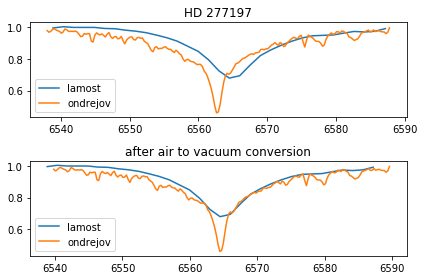

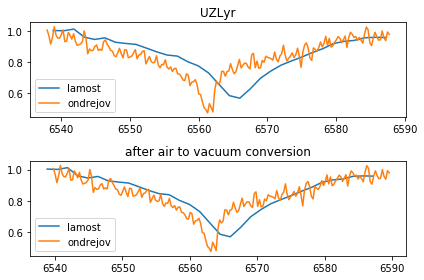

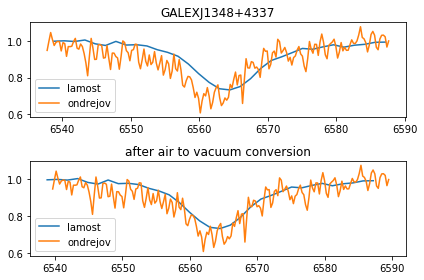

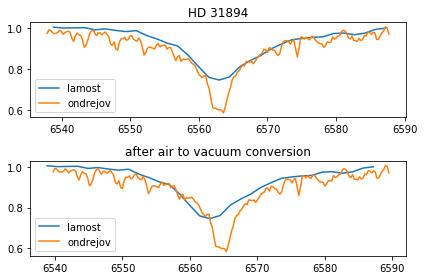

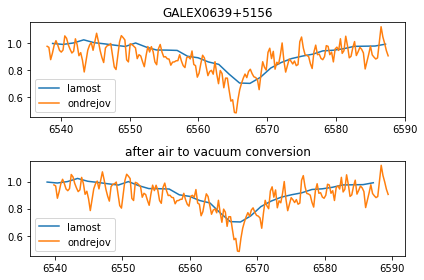

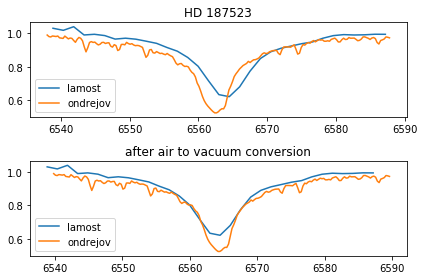

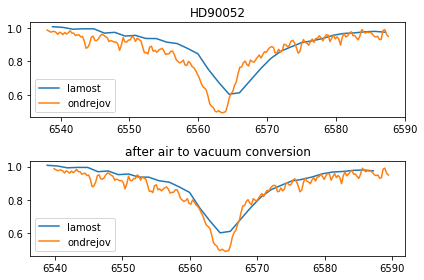

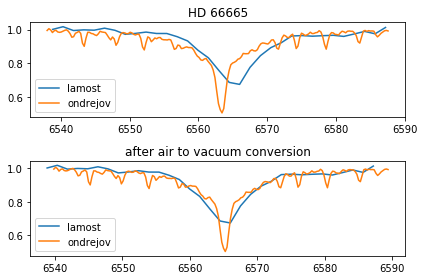

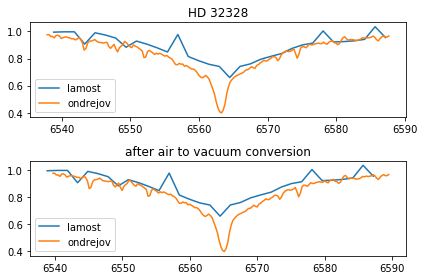

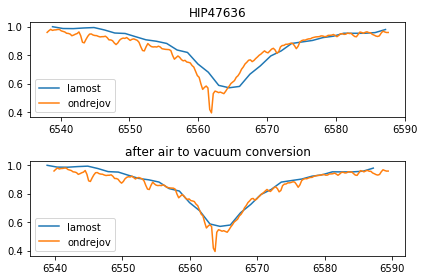

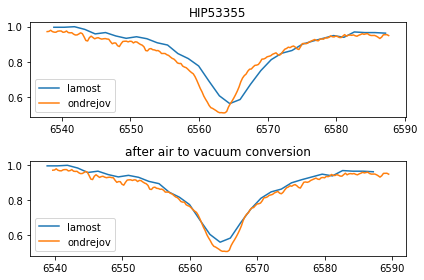

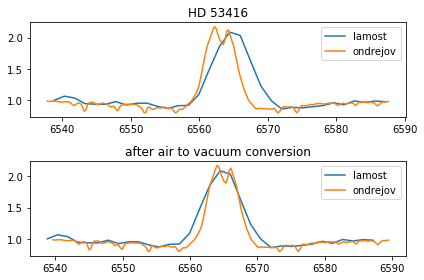

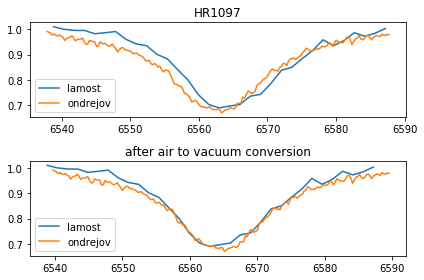

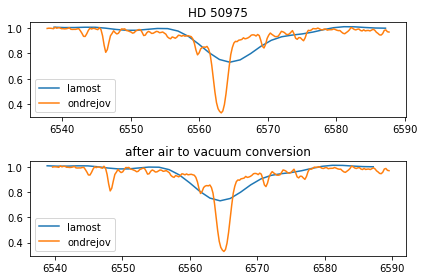

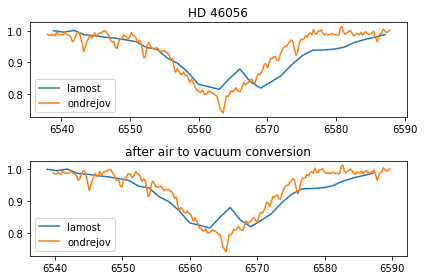

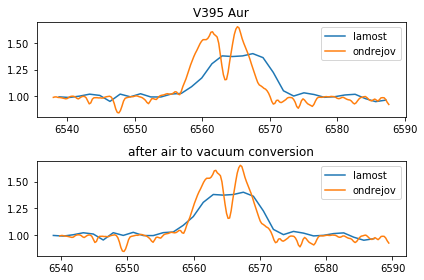

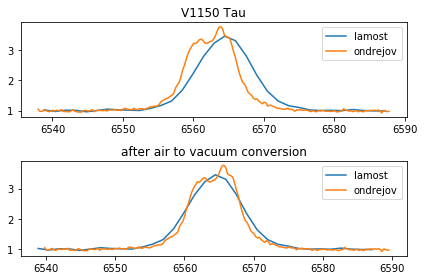

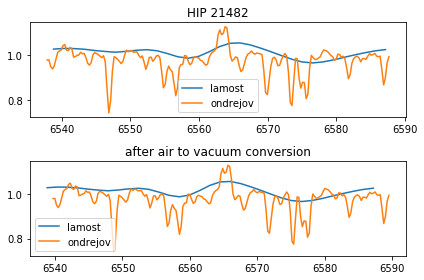

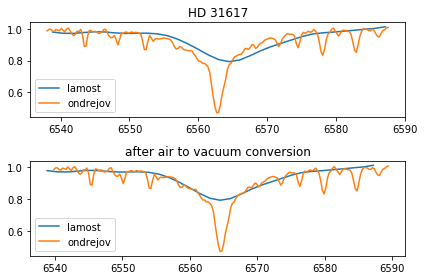

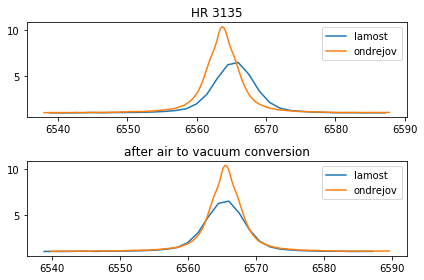

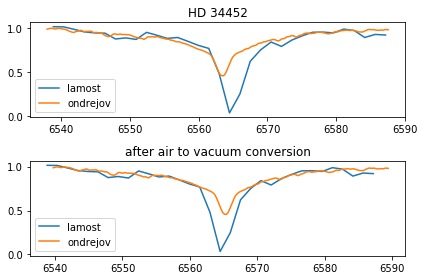

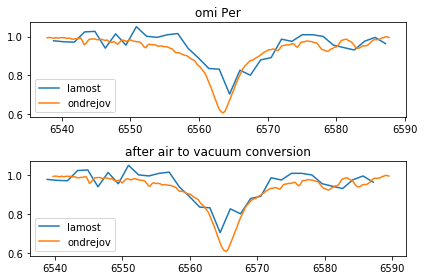

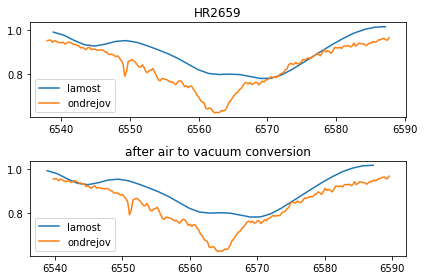

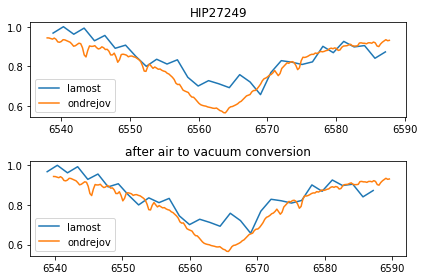

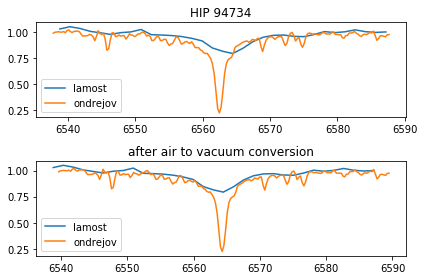

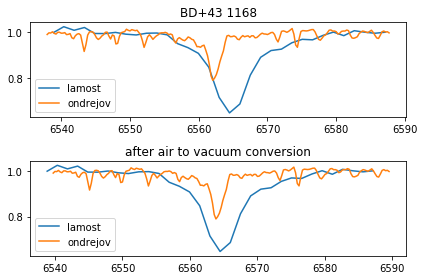

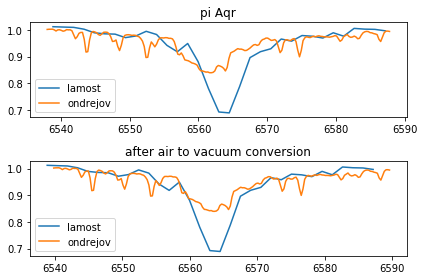

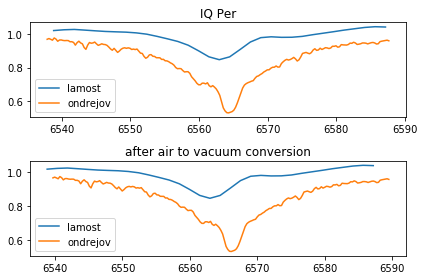

In [10]:
# preview the conversion on matched spectra
for path in matched_paths:
    with fits.open(path[0]) as ond_hdulist, fits.open(path[1]) as lam_hdulist:
        # get cutted spectra
        lam_waves, lam_fluxes = utils.cut_spectrum(*lamost.get_spectrum(lam_hdulist), START, END)
        ond_waves, ond_fluxes = utils.cut_spectrum(*ondrejov.get_spectrum(ond_hdulist), START, END)
        
        f, (ax1, ax2) = plt.subplots(2, 1)
        
        ax1.set_title(ond_hdulist[1].header['OBJECT'])
        ax1.plot(lam_waves, lam_fluxes, label='lamost')
        ax1.plot(ond_waves, ond_fluxes, label='ondrejov')
        ax1.legend()

        ax2.set_title('after air to vacuum conversion')
        ax2.plot(lam_waves, lam_fluxes, label='lamost')
        
        # the implemented conversion function
        ond_vacuum_waves = utils.air2vacuum(ond_waves)
        ax2.plot(ond_vacuum_waves, ond_fluxes, label='ondrejov')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

## Convolution

**Dead end:** Area under a curve won't work for determing the standard deviation of Gaussian kernel.

LAMOST and Ondřejov spectragraphs has different spectral resolving powers.
LAMOST has between 500-1800 while Ondřejov has about 13000.
That means the spectra from LAMOST are blurred.
Therefore Gaussian blur should be applied to Ondřejov spectra to remove the detail LAMOST cannot capture.

[Gaussia blur](https://en.wikipedia.org/wiki/Gaussian_blur) has primarily standard deviation paramater
which needs to be determined. **But that's incredibly hard to do correctly.**

In [11]:
# LAMOST spectral resolution power / min and max of Ondřejov
print('Standard deviation should be between {} and {}.'.format(13000 / 1800, 13000 / 1000))

Standard deviation should be between 7.222222222222222 and 13.0.


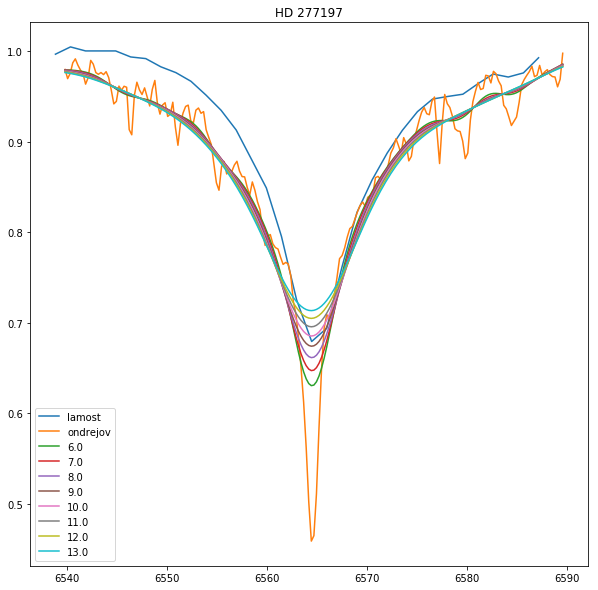

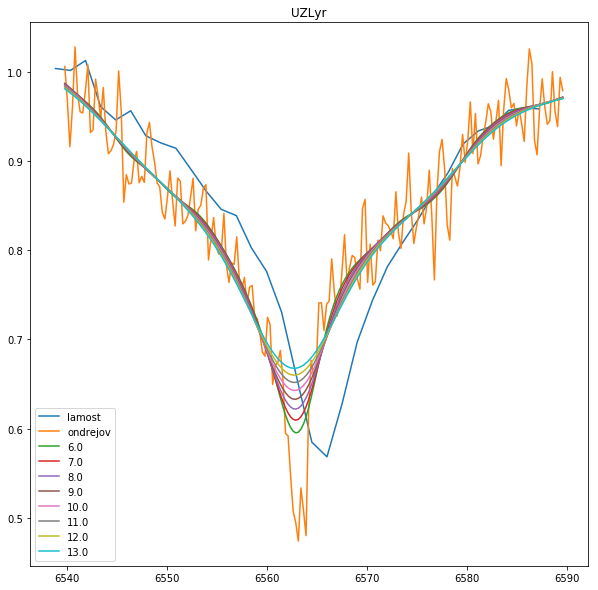

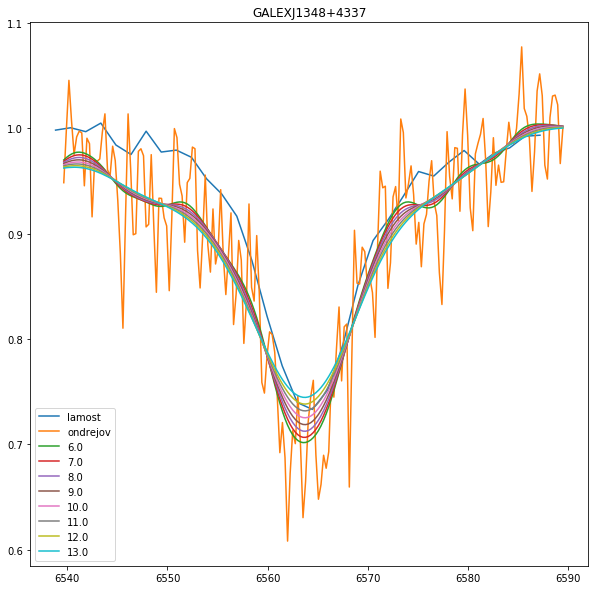

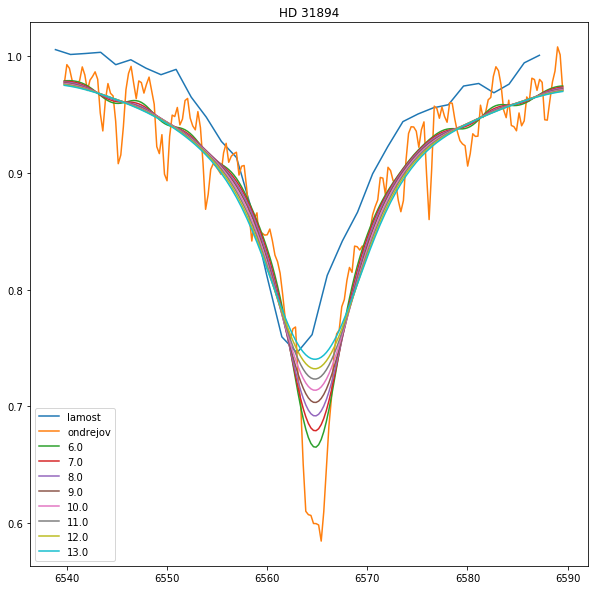

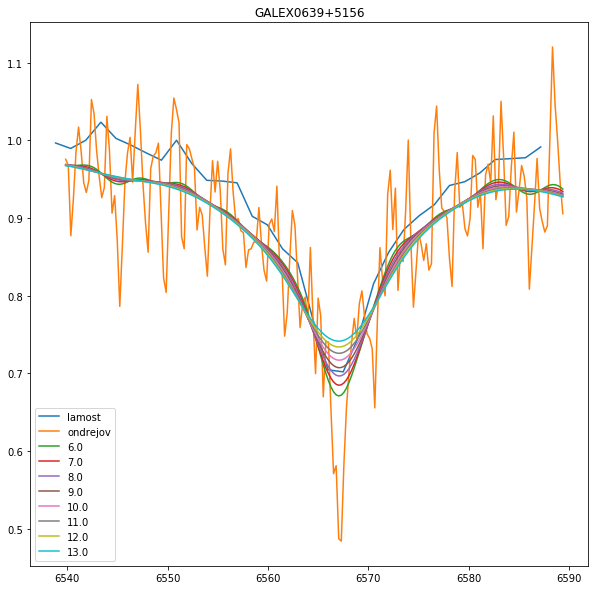

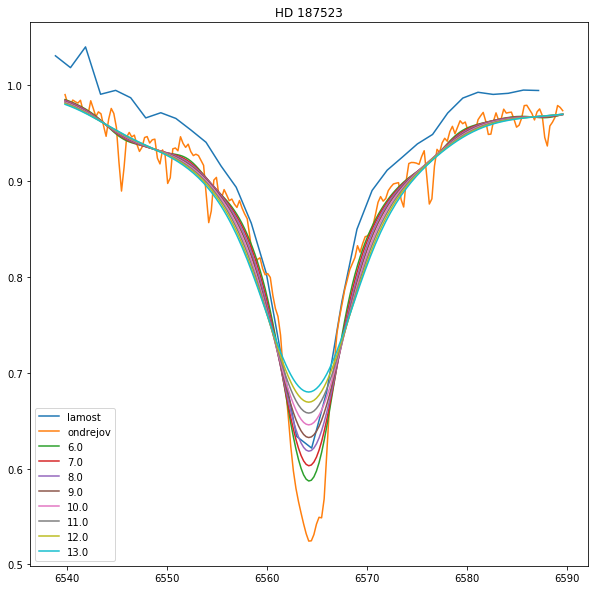

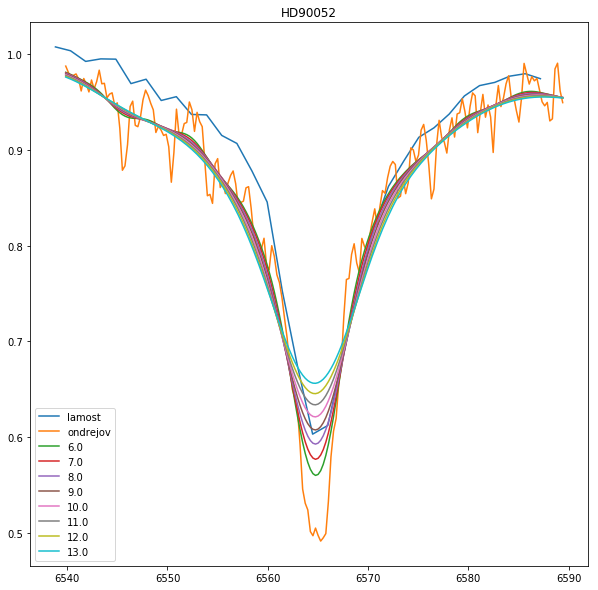

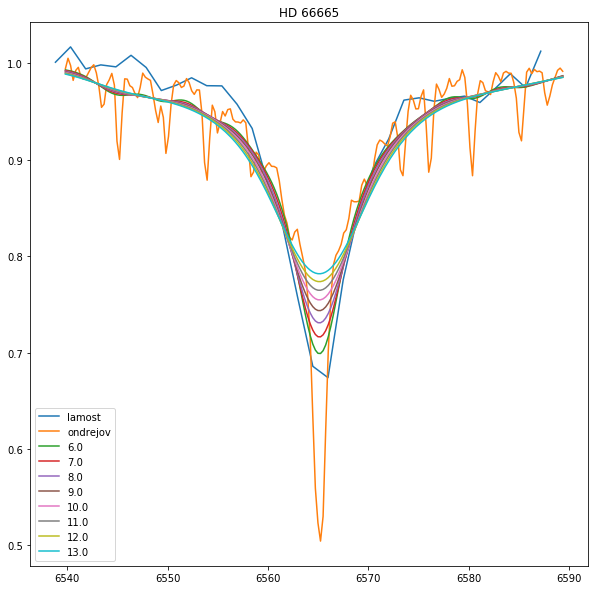

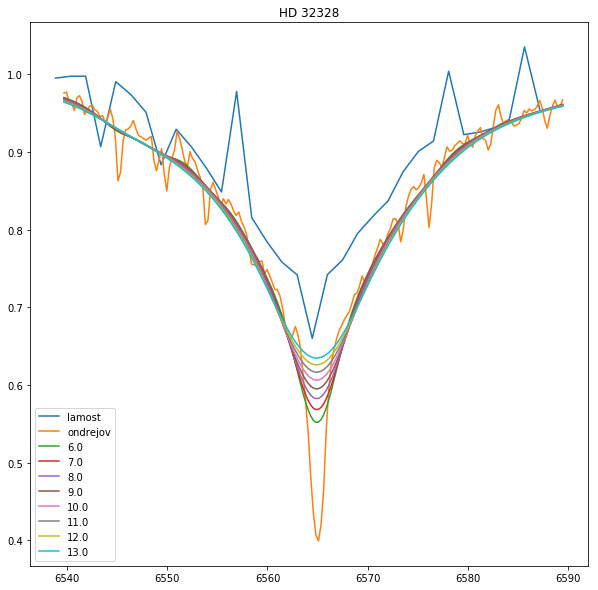

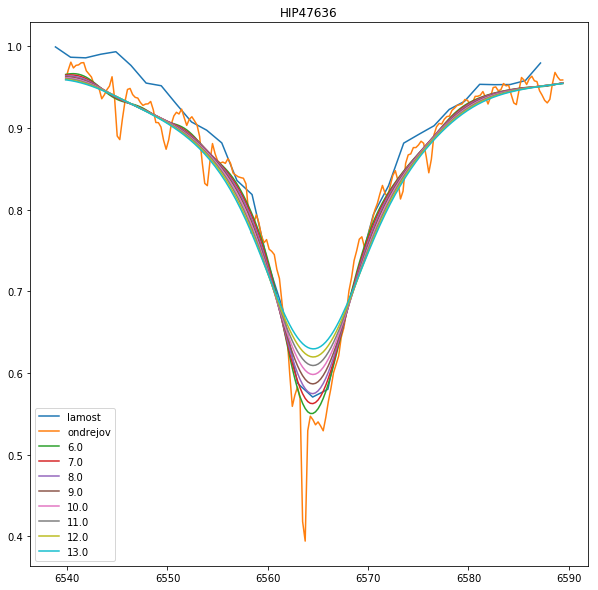

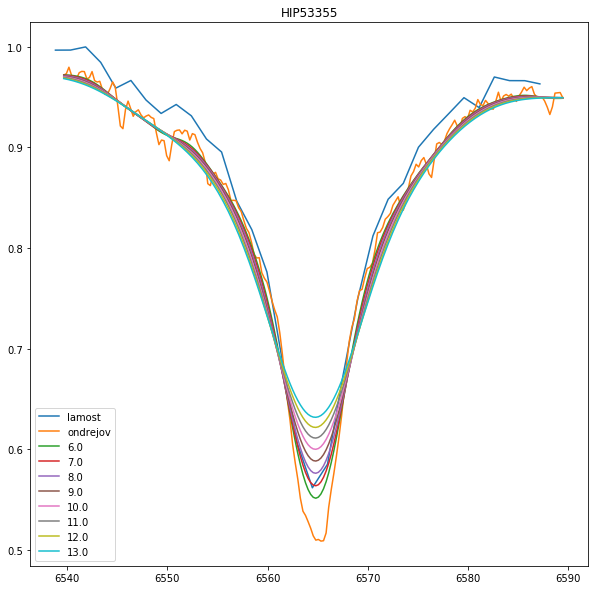

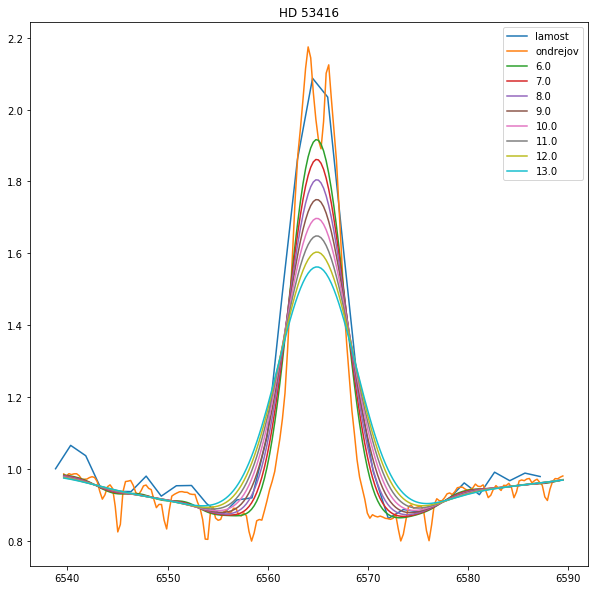

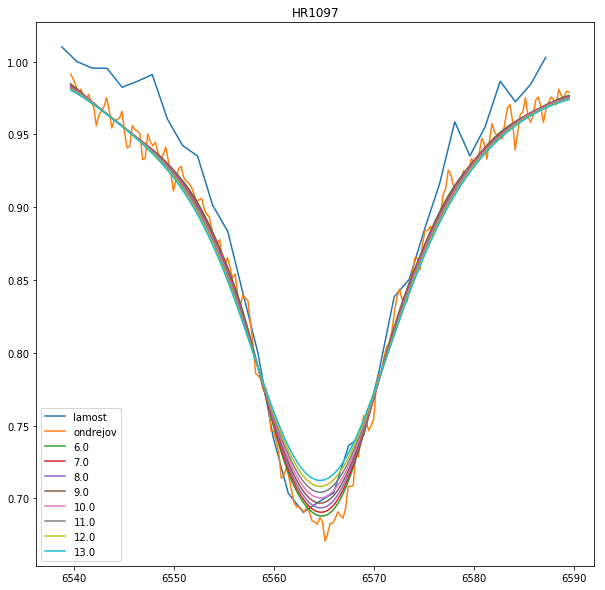

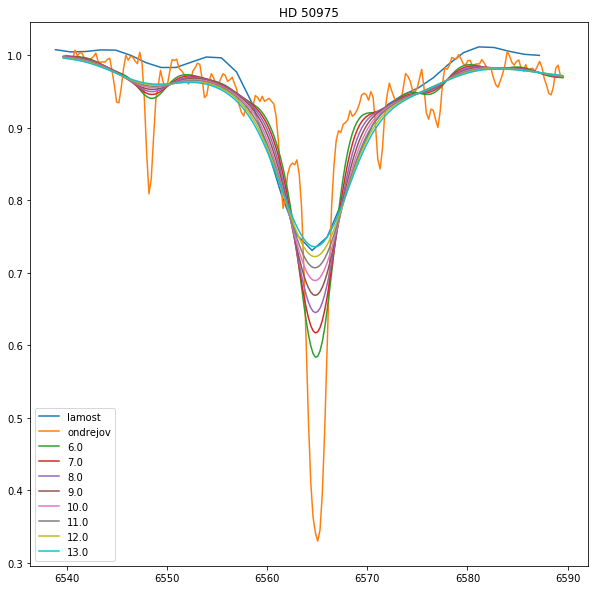

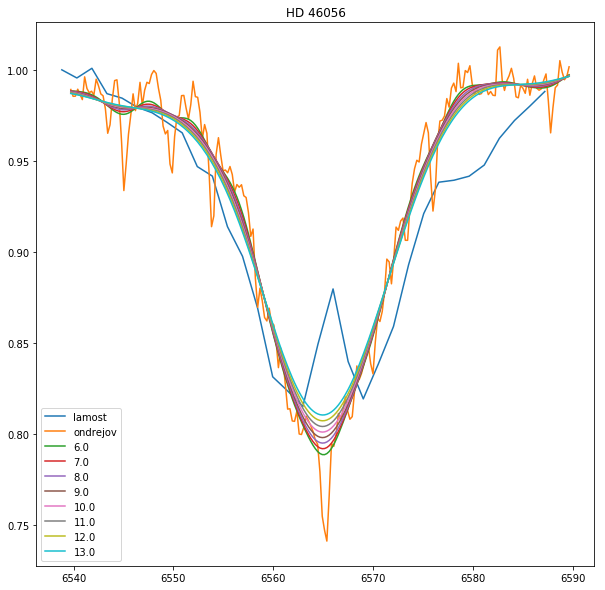

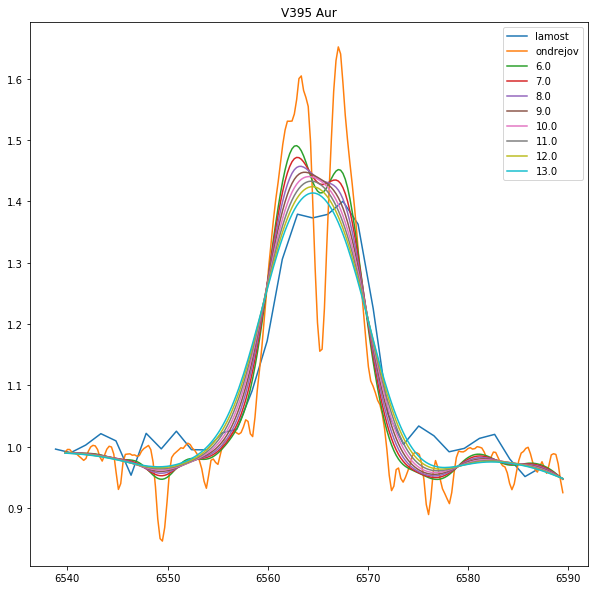

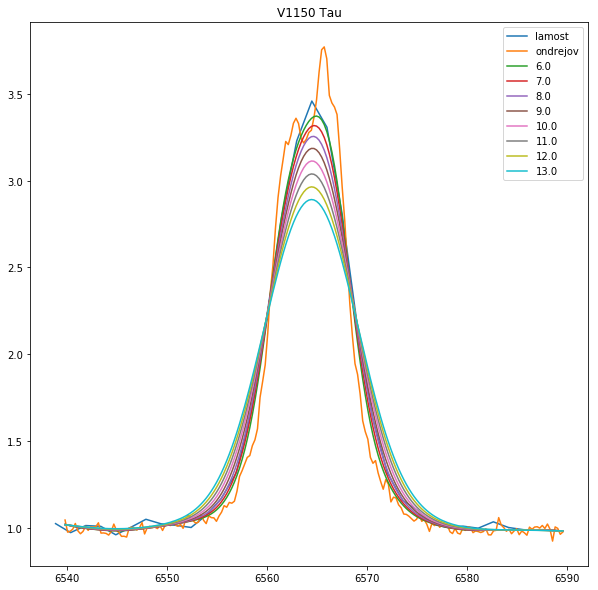

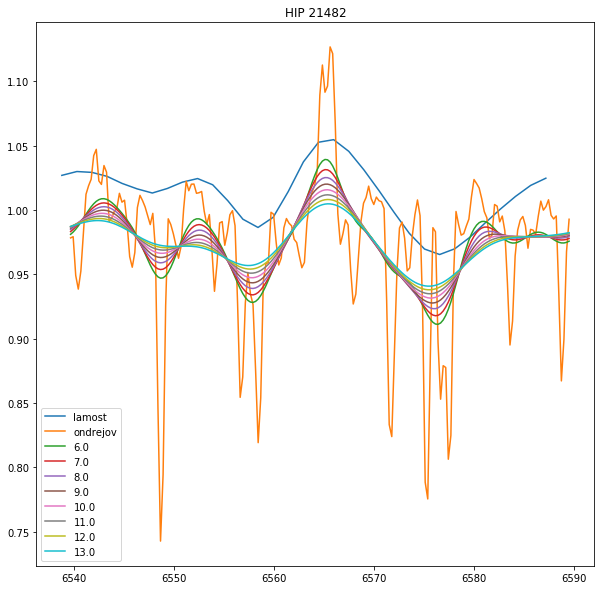

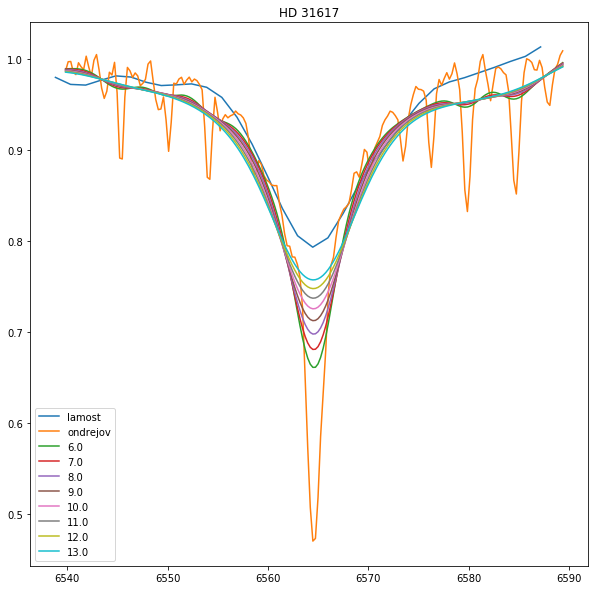

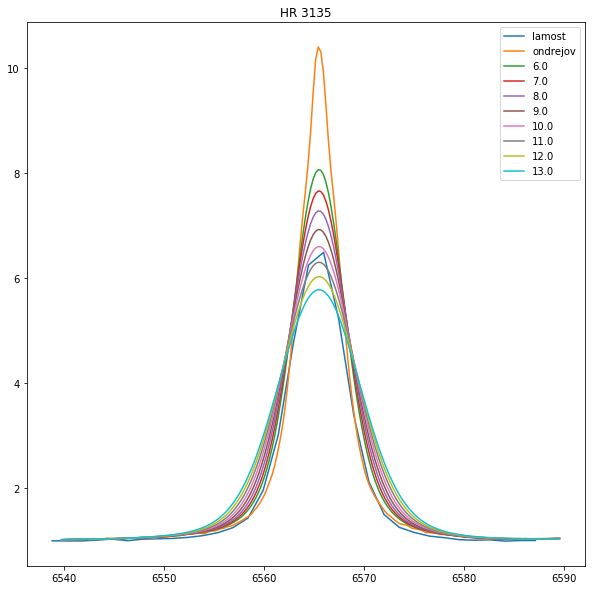

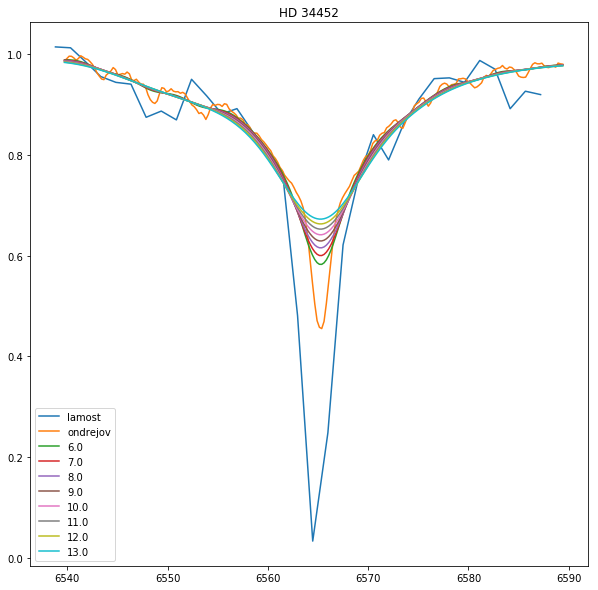

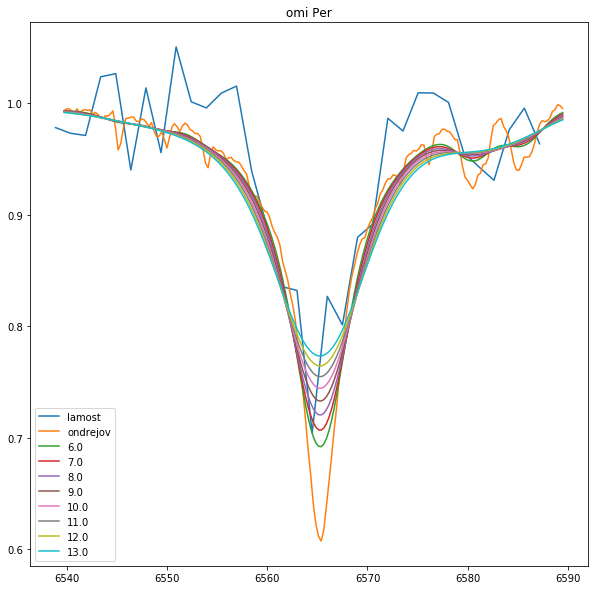

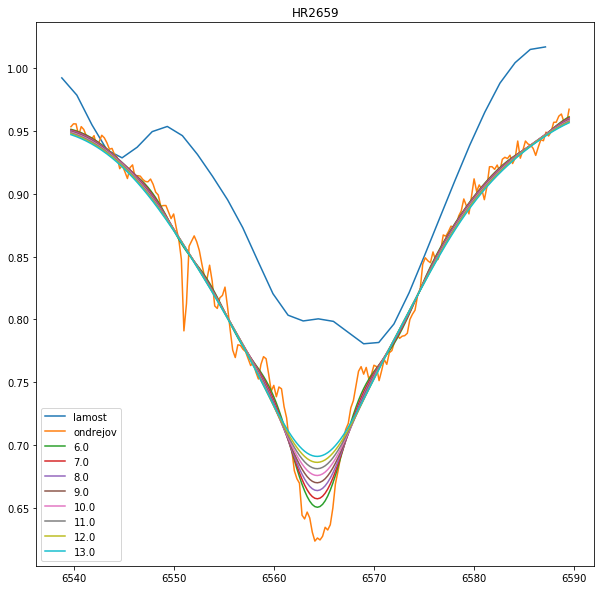

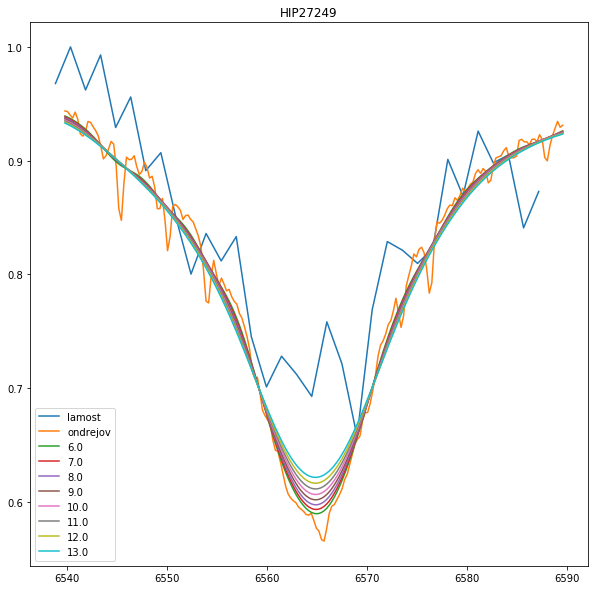

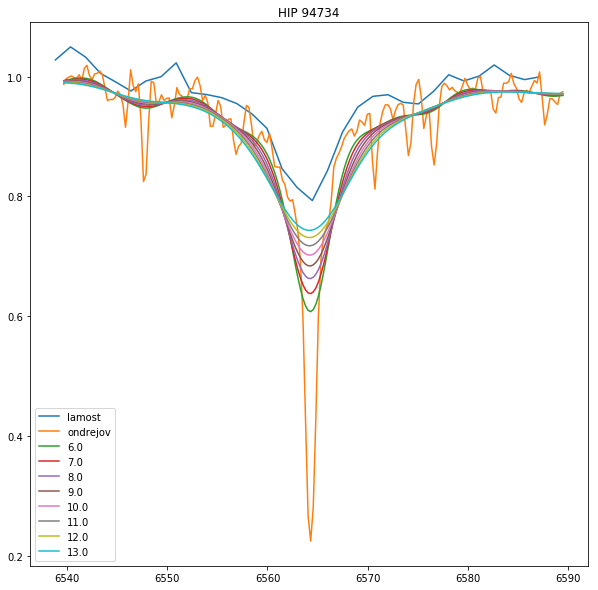

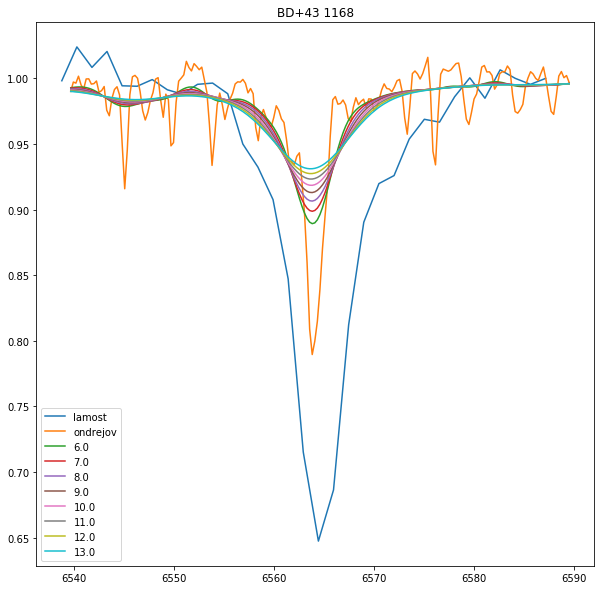

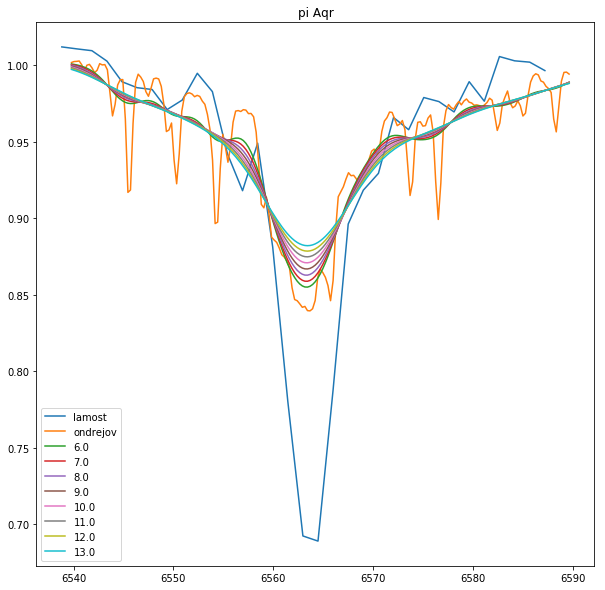

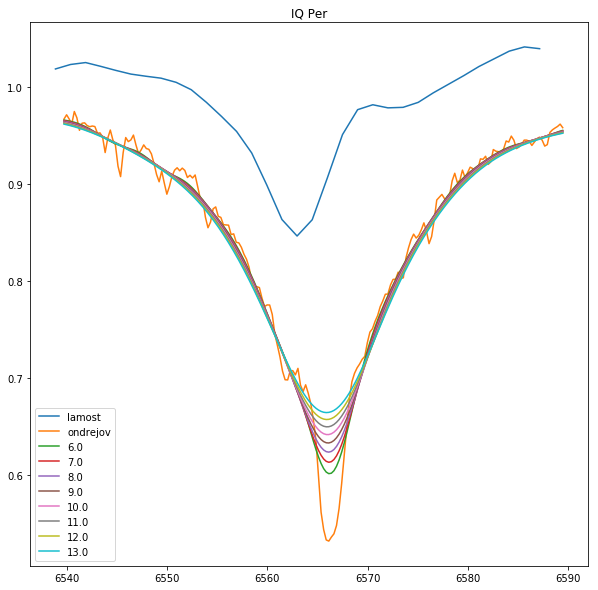

In [12]:
for path in matched_paths:
    with fits.open(path[0]) as ond_hdulist, fits.open(path[1]) as lam_hdulist:
        lam_waves, lam_fluxes = utils.cut_spectrum(*lamost.get_spectrum(lam_hdulist), START, END)
        ond_waves, ond_fluxes = utils.cut_spectrum(*ondrejov.get_spectrum(ond_hdulist), START, END)
        
        new_ond_waves = utils.air2vacuum(ond_waves)    # convert waves
        
        plt.figure(figsize=(10, 10))
        plt.title(ond_hdulist[1].header['OBJECT'])
        
        plt.plot(lam_waves, lam_fluxes, label='lamost')
        plt.plot(new_ond_waves, ond_fluxes, label='ondrejov')
        
        # try different gaussian blurs
        for stddev in np.linspace(6, 13, num=8):
            kernel = Gaussian1DKernel(stddev)
            ond_fluxes_conv = convolve(ond_fluxes, kernel, boundary='extend')
            plt.plot(new_ond_waves, ond_fluxes_conv, label=str(stddev))
        
        plt.legend()
        plt.show()